In [1]:
from __future__ import annotations

import numpy as np
import pandas as pd

import scanpy as sc
import anndata as ad
import decoupler
import seaborn.objects as so

import session_info

In [2]:
# 设置参数
import matplotlib as mpl

mpl.rcParams["pdf.fonttype"] = 42  # 保留字体
sc.settings.verbosity = 4  # 输出细节
sc._settings.ScanpyConfig.n_jobs = -1  # 使用所有核心
sc.settings.set_figure_params(
    dpi=80,
    dpi_save=600,
    facecolor="white",
    frameon=False,  # remove frame
)

In [3]:
# Filtering warnings from current version of matplotlib
import warnings

warnings.filterwarnings(
    "ignore", message=".*Parameters 'cmap' will be ignored.*", category=UserWarning
)
warnings.filterwarnings(
    "ignore", message="Tight layout not applied.*", category=UserWarning
)

In [4]:
# Setting up R dependencies
import rpy2
from rpy2.robjects import r
import random
from rpy2.robjects import pandas2ri, numpy2ri

pandas2ri.activate()
numpy2ri.activate()

%load_ext rpy2.ipython


In [5]:
%%R
suppressPackageStartupMessages({
    library(SingleCellExperiment)
})

In [6]:
ANNO_COL = "manual_celltype_annotation"
adata = sc.read("./anndata_manual_anno.h5ad")
adata_tmp = adata.raw.to_adata()
adata_tmp.obs = adata.obs
adata = adata_tmp
adata

/home/fanxi/miniconda3/envs/lang/lib/python3.11/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 100443 × 17269
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'keep', 'RNA_snn_res.0.3', 'RNA_snn_res.0.6', 'RNA_snn_res.1', 'RNA_snn_res.1.2', 'seurat_clusters', 'pANN', 'DF.classifications', 'RNA_snn_res.1.4', 'RNA_snn_res.1.6', 'cell_type', 'ident', 'sample', 'group', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'outlier', 'mt_outlier', 'discard', 'doublet_score', 'predicted_doublet', 'size_factors', '_scvi_batch', '_scvi_labels', 'leiden', 'leiden_0_25', 'leiden_0_5', 'leiden_2', 'leiden_00_25', 'leiden_00_5', 'manual_celltype_ann

In [7]:
# adata.obs = adata.obs.rename({"condition": "group"}, axis=1) #失效
# adata.obs = adata.obs.rename({"cell_type": "celltypist_cell_label_coarse"}, axis=1)
adata.obs["cell_type"] = adata.obs[ANNO_COL]
adata.obs["condition"] = adata.obs["group"]

While the current object comes with UMAP and PCA embeddings, these have been corrected for stimulation condition, which we don't want for this analysis. Instead we will recompute these.


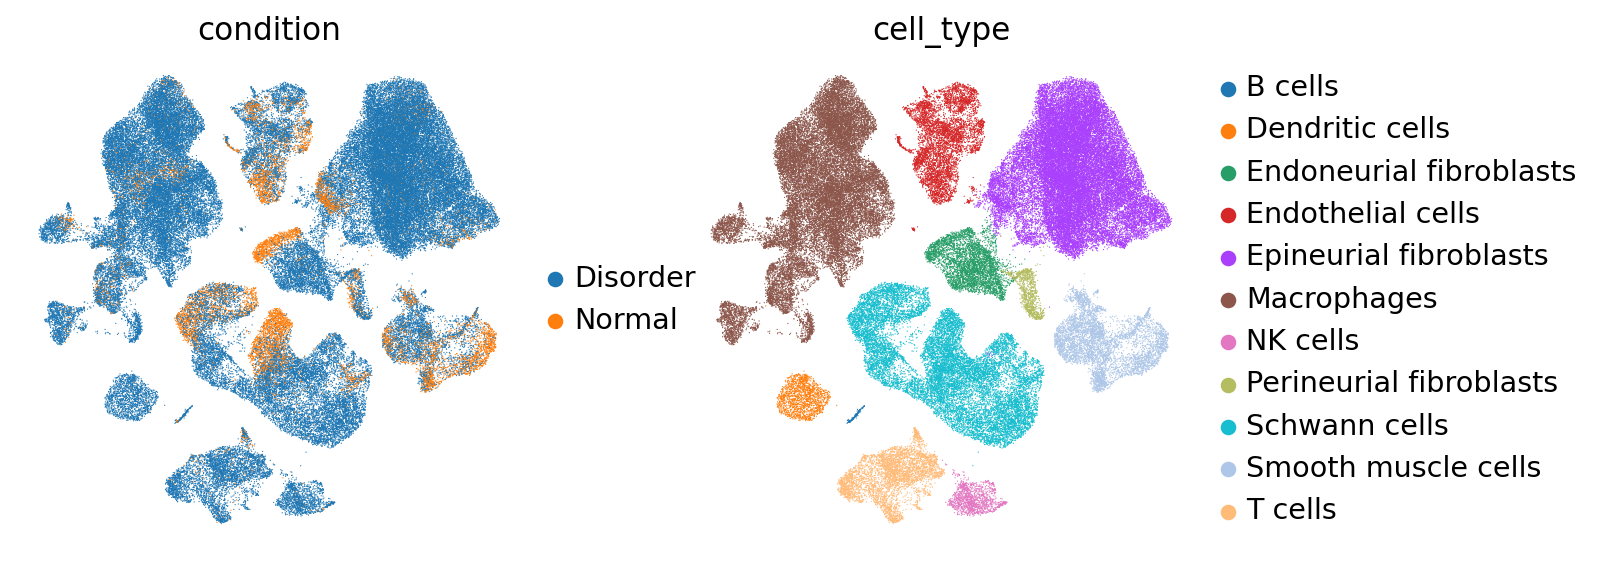

In [8]:
sc.pl.umap(
    adata,
    color=["condition", "cell_type"],
    frameon=False,
    ncols=2,
)

We generally recommend determining the differentially expressed genes as outlined in the `Differential gene expression` chapter. For simplicity, here we run a t-test using `rank_genes_groups` in `scanpy` to rank genes according to their test statistics for differential expression:


In [9]:
adata.obs["group"] = adata.obs.condition.astype("string") + "_" + adata.obs.cell_type

In [10]:
## 对数化
adata.layers["counts"] = adata.X.copy()
# Normalizing
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

In [11]:
# Finding highly variable genes using count data
sc.pp.highly_variable_genes(
    adata, n_top_genes=5000, flavor="seurat_v3", subset=False, layer="counts"
)

Let's extract the ranks for genes differentially expressed in response to IFN stimulation in the CD16 Monocyte (FCGR3A+ Monocytes) cluster. We use these ranks and the gene sets from REACTOME to find gene sets enriched in this cell population compared to all other populations using `GSEA` as implemented in decoupler.


In [12]:
# 重新计算嵌入，因为之前的矫正过
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

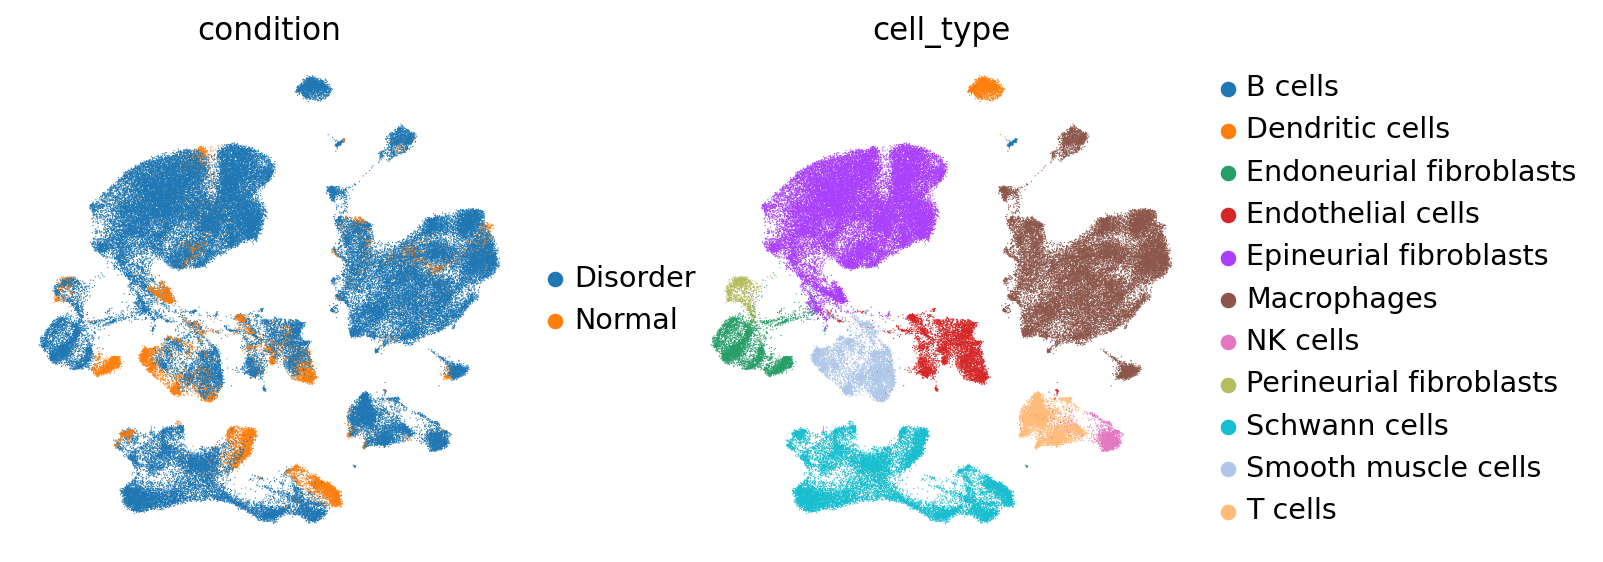

In [13]:
sc.pl.umap(
    adata,
    color=["condition", "cell_type"],
    frameon=False,
    ncols=2,
)

In [14]:
adata.obs["group"] = adata.obs.condition.astype("string") + "_" + adata.obs.cell_type

In [15]:
# find DE genes by t-test
sc.tl.rank_genes_groups(adata, "group", method="t-test", key_added="t-test")

/home/fanxi/miniconda3/envs/lang/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/home/fanxi/miniconda3/envs/lang/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:398: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/home/fanxi/miniconda3/envs/lang/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:401: PerformanceWa

In [16]:
adata.obs["group"].value_counts()

Disorder_Epineurial fibroblasts     32278
Disorder_Macrophages                26426
Disorder_Schwann cells              11916
Disorder_T cells                     4174
Disorder_Endothelial cells           4132
Normal_Schwann cells                 3579
Disorder_Smooth muscle cells         3362
Disorder_Endoneurial fibroblasts     3352
Normal_Smooth muscle cells           2007
Normal_Endothelial cells             1651
Disorder_Dendritic cells             1573
Disorder_NK cells                    1332
Normal_Epineurial fibroblasts        1231
Normal_Macrophages                   1132
Normal_Endoneurial fibroblasts        877
Disorder_Perineurial fibroblasts      769
Normal_Perineurial fibroblasts        280
Normal_T cells                        163
Disorder_B cells                      158
Normal_NK cells                        26
Normal_B cells                         20
Normal_Dendritic cells                  5
Name: group, dtype: int64

In [17]:
"""
sc.tl.rank_genes_groups(adata, "group", method="t-test", key_added="t-test")
决定了与剩下的所有细胞类型比较，得到的是一个dataframe，包含了每个基因的t-test值，以及p值，fdr等
sc.tl.rank_genes_groups(adata, groupby='celltype', groups=['group1'], reference='group2', method='t-test')
指定reference

"""
celltype_condition = "Normal_Schwann cells"  #

# extract scores
t_stats = (
    # Get dataframe of DE results for condition vs. rest
    sc.get.rank_genes_groups_df(adata, celltype_condition, key="t-test")
    # Subset to highly variable genes
    .set_index("names")
    .loc[adata.var["highly_variable"]]
    # Sort by absolute score
    .sort_values("scores", key=np.abs, ascending=False)
    # Format for decoupler
    [["scores"]]
    .rename_axis(["stim_FCGR3A+ Monocytes"], axis=1)
)
t_stats

stim_FCGR3A+ Monocytes,scores
names,
Igf1,-219.278946
Fn1,-202.833511
Sfrp2,-178.961792
Cd53,-174.801163
Tyrobp,-172.725815
...,...
Cenpm,0.021074
Uchl1,-0.018670
Vsig2,-0.011222


categories: B cells, Dendritic cells, Endoneurial fibroblasts, etc.
var_group_labels: Disorder_B cells, Disorder_Dendritic cells, Disorder_Endoneurial fibroblasts, etc.


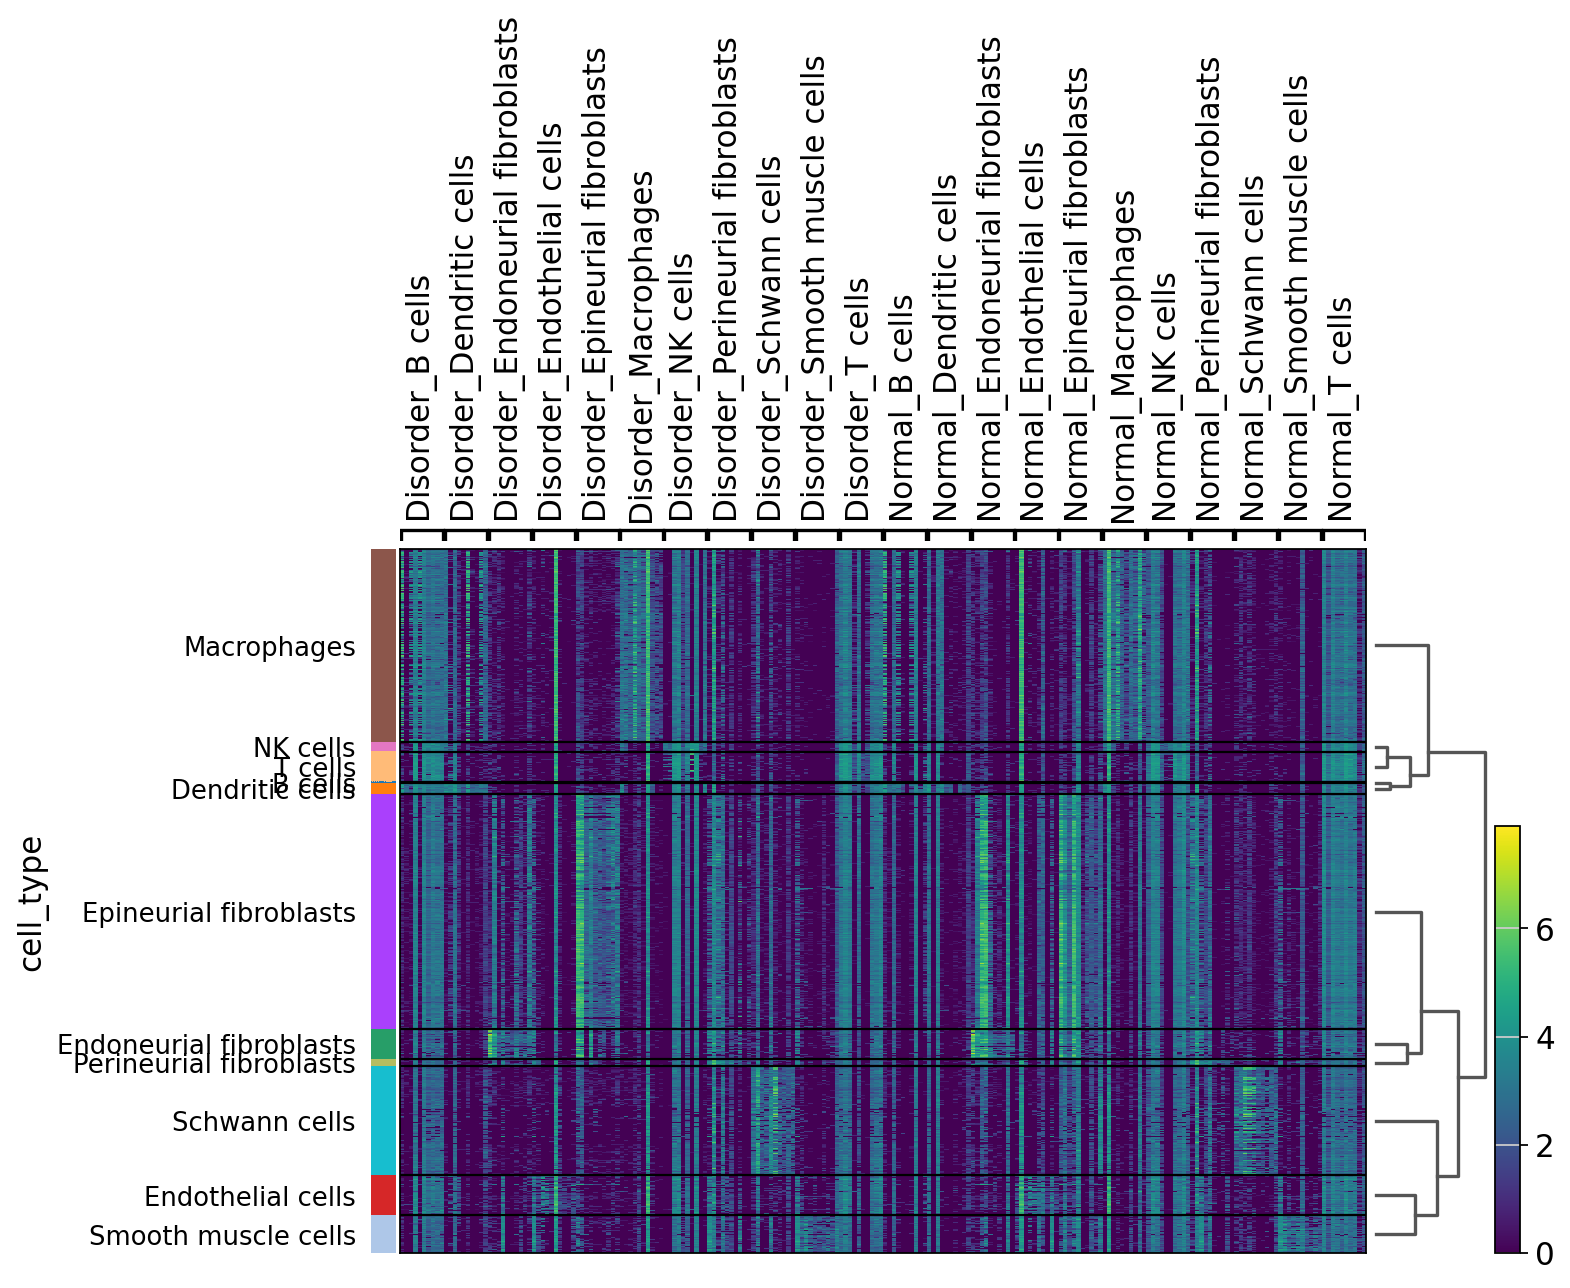

In [20]:
sc.pl.rank_genes_groups_heatmap(adata,key="t-test", groupby = "cell_type")

### Cluster-level gene set enrichment analysis with `decoupler`


Now we will use the python package [`decoupler`](https://decoupler-py.readthedocs.io/en/latest/) {cite}`badia2022decoupler` to perform GSEA enrichment tests on our data.


#### Retrieving gene sets


Download and read the `gmt` file for the REACTOME pathways annotated in the C2 collection of MSigDB.


In [22]:
# Downloading reactome pathways
from pathlib import Path

if not Path("c2.cp.reactome.v7.5.1.symbols.gmt").is_file():
    !wget -O 'c2.cp.reactome.v7.5.1.symbols.gmt' https://figshare.com/ndownloader/files/35233771

In [23]:
## 下载并阅读gmtMSigDB C2 集合中注释的 REACTOME 路径文件。
def gmt_to_decoupler(pth: Path) -> pd.DataFrame:
    """
    Parse a gmt file to a decoupler pathway dataframe.
    """
    from itertools import chain, repeat

    pathways = {}

    with Path(pth).open("r") as f:
        for line in f:
            name, _, *genes = line.strip().split("\t")
            pathways[name] = genes

    return pd.DataFrame.from_records(
        chain.from_iterable(zip(repeat(k), v) for k, v in pathways.items()),
        columns=["geneset", "genesymbol"],
    )

In [24]:
reactome = gmt_to_decoupler("c2.cp.reactome.v7.5.1.symbols.gmt")

Alternatively, we could just query for these resources from omnipath.

However, for stability of this tutorial we are using a fixed version of the gene set collection.


In [24]:
# 在线获取 更多
msigdb = decoupler.get_resource("MSigDB")

# Get reactome pathways
reactome = msigdb.query("collection == 'reactome_pathways'")
# Filter duplicates
reactome = reactome[~reactome.duplicated(("geneset", "genesymbol"))]

In [25]:
reactome = reactome[["geneset", "genesymbol"]]  # 选择列
# reactome = reactome.iloc[:, [2,0]] 按索引取列
reactome

,geneset,genesymbol
200,REACTOME_HEMOSTASIS,MAFF
342,REACTOME_FACTORS_INVOLVED_IN_MEGAKARYOCYTE_DEV...,MAFF
718,REACTOME_INTRACELLULAR_SIGNALING_BY_SECOND_MES...,IER3
859,REACTOME_NEGATIVE_REGULATION_OF_THE_PI3K_AKT_N...,IER3
1104,REACTOME_MITOTIC_G2_G2_M_PHASES,PHLDA1
...,...,...
3838483,REACTOME_DAP12_INTERACTIONS,KIR2DS2
3838489,REACTOME_INNATE_IMMUNE_SYSTEM,KIR2DS2
3838499,REACTOME_ADAPTIVE_IMMUNE_SYSTEM,KIR2DS2
3838530,REACTOME_DAP12_INTERACTIONS,KIR3DS1


#### Running GSEA


First we'll prepare our gene sets. By default `decoupler` will not filter gene sets by maximum size, which packages like `fgsea` do. Instead we will simply manually filter gene sets to have a minimum of 15 genes and a maximum of 500 genes.


In [26]:
# Filtering genesets to match behaviour of fgsea
"""
默认情况下，decoupler不会按最大大小过滤基因集，而类似的包fgsea会这样做。
相反，我们将简单地手动过滤基因集，使其最少有 15 个基因，最多有 500 个基因。
"""
geneset_size = reactome.groupby("geneset").size()
gsea_genesets = geneset_size.index[(geneset_size > 15) & (geneset_size < 500)]

We'll uses the t-statistics from the t-test to rank the genes for the CD16 Monocyte phenotype upon IFN stimulation and computes p-values for each of the pathways.


In [27]:
"""
使用 t 检验中的对干预后某细胞表型的基因进行排序，并计算每个途径的 p 值。
他默认按p值升序排序，但是p为0没有结果
pval是富集测试的 p 值，
而score和norm分别是富集分数和归一化富集分数。
负分数表明该途径被下调，正分数表明该途径或基因集中的基因上调。
"""
scores, norm, pvals = decoupler.run_gsea(
    t_stats.T,
    reactome[reactome["geneset"].isin(gsea_genesets)],
    source="geneset",
    target="genesymbol",
)

gsea_results = (
    pd.concat({"score": scores.T, "norm": norm.T, "pval": pvals.T}, axis=1)
    .droplevel(level=1, axis=1)
    .sort_values("score", ascending=False)  # 按照score降序排序
)
gsea_results

ValueError: No sources with more than min_n=5 targets. Make sure mat and net have shared target features or
        reduce the number assigned to min_n

In [29]:
"""
Cell generated by Data Wrangler.
"""


def clean_data(gsea_results):
    gsea_results["pval"].replace(0, np.nan, inplace=True)
    min_pval = gsea_results["pval"].min()

    # Replace NaNs (originally 0) with half of the minimum non-zero p-value
    gsea_results["pval"].replace(np.nan, min_pval / 2, inplace=True)
    # Filter rows based on column: 'pval'
    gsea_results = gsea_results[gsea_results["pval"] < 0.05]
    return gsea_results


gsea_results_clean = clean_data(gsea_results.copy())
gsea_results_clean.head()

,score,norm,pval
source,,,
REACTOME_TP53_REGULATES_TRANSCRIPTION_OF_ADDITIONAL_CELL_CYCLE_GENES_WHOSE_EXACT_ROLE_IN_THE_P53_PATHWAY_REMAIN_UNCERTAIN,0.822663,1.583729,0.049505
REACTOME_SYNTHESIS_OF_PIPS_AT_THE_PLASMA_MEMBRANE,0.801445,1.761092,0.012712
REACTOME_RHOBTB1_GTPASE_CYCLE,0.800633,1.565662,0.047970
REACTOME_DUAL_INCISION_IN_TC_NER,0.789746,1.737319,0.008403
REACTOME_RRNA_MODIFICATION_IN_THE_NUCLEUS_AND_CYTOSOL,0.789363,1.671425,0.027237


We make a bar plot of top 20 pathways significantly enriched in stimulated CD16 Monocytes compared to all other cell types.


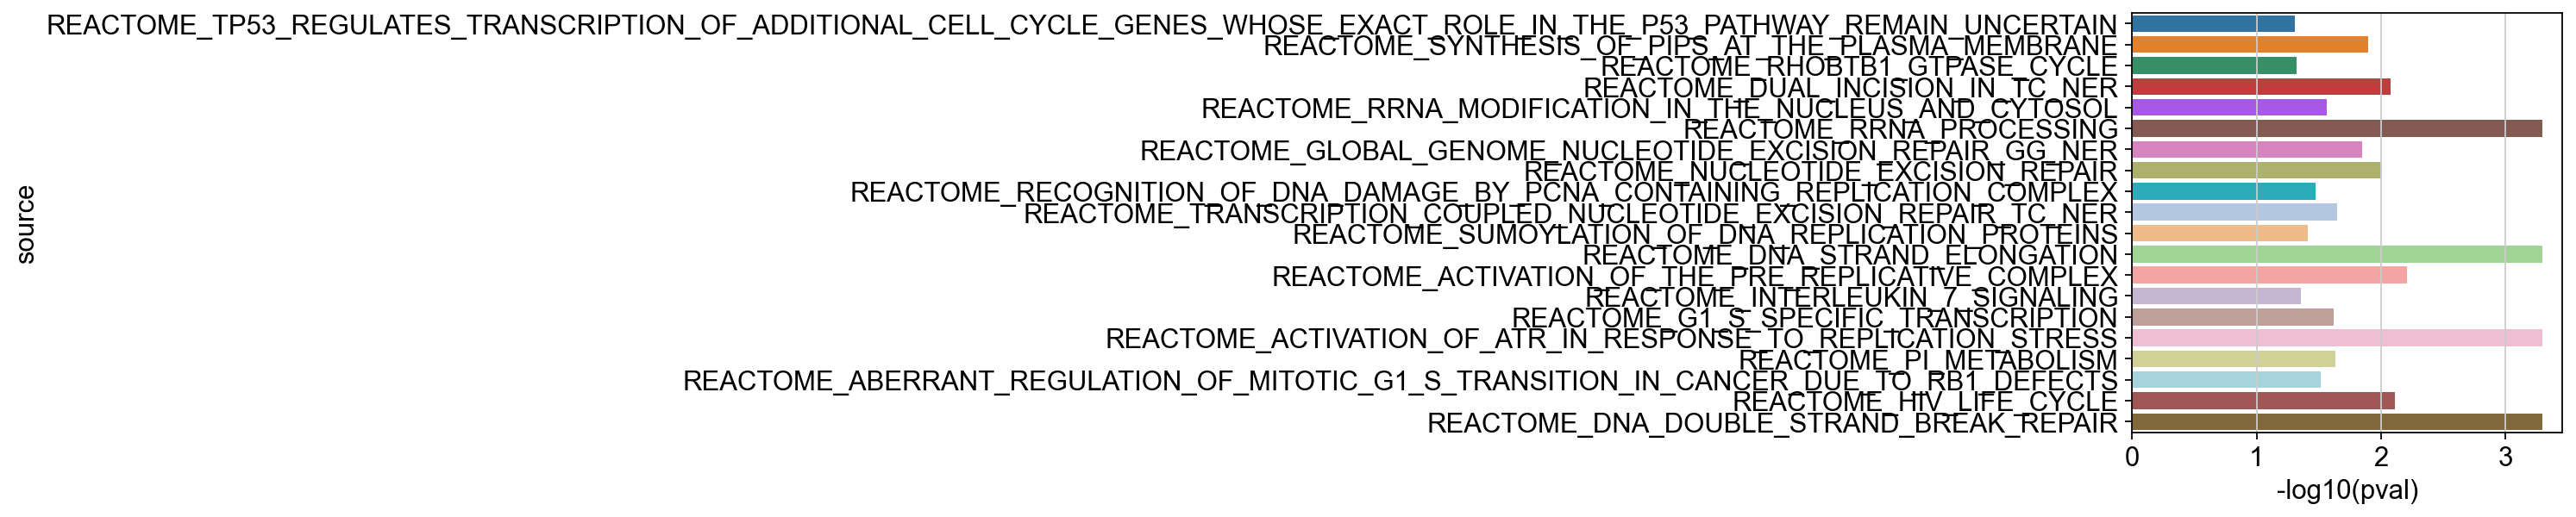

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

# Reset the index of the DataFrame to turn the index into a column
gsea_results_reset = (
    gsea_results_clean.head(20)
    .assign(**{"-log10(pval)": lambda x: -np.log10(x["pval"])})
    .reset_index()
)

# Now 'geneset' is a column and can be referenced directly in sns.barplot
sns.barplot(data=gsea_results_reset, x="-log10(pval)", y="source")

plt.show()

/home/fanxi/miniconda3/envs/lang/lib/python3.11/site-packages/seaborn/_core/plot.py:1491: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context("mode.use_inf_as_na", True):


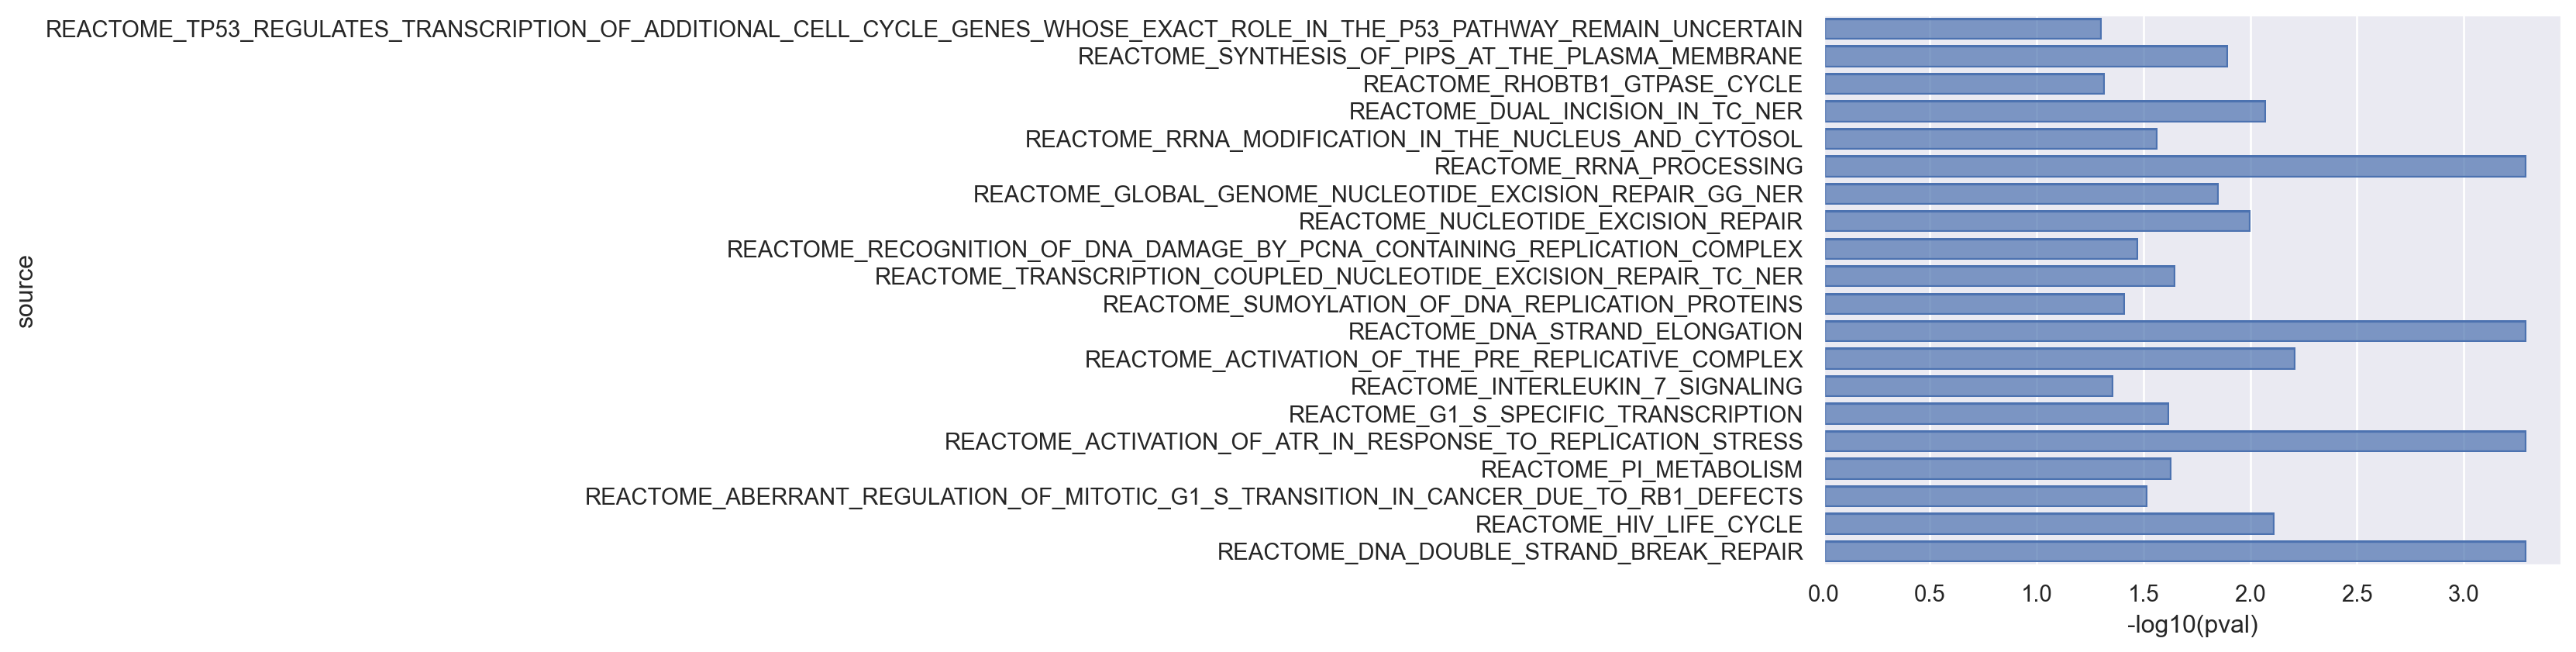

In [31]:
(
    so.Plot(
        data=(
            gsea_results_clean.head(20).assign(
                **{"-log10(pval)": lambda x: -np.log10(x["pval"])}
            )
        ),
        x="-log10(pval)",
        y="source",
    ).add(so.Bar())
)

In the plot above, pathway names are given in the y-axis. The x-axis describes the $-\log_{10}$adjusted p-values. Therefore, the longer the height of the bar, the more significant the pathway is. Pathways are ordered by significance. The majority of interferon-related pathways are indeed ranked among the top 20 most significantly enriched pathways. Some IFN-related pathways include, REACTOME_INTERFERON_SIGNALING (ranked 2nd), REACTOME_INTERFERON_GAMMA_SIGNALING (ranked 3rd), and REACTOME_INTERFERON_ALPHA_BETA_SIGNALING (ranked 4th). Overall, `GSEA` did a decent job in identifying the pathways known to be associated with interferon signalling, given that we know a priori that IFN-related pathways should be the top-ranked terms.


Let's look at the raw output of `decoupler.run_gsea`:


In [32]:
gsea_results_clean.head(10)

,score,norm,pval
source,,,
REACTOME_TP53_REGULATES_TRANSCRIPTION_OF_ADDITIONAL_CELL_CYCLE_GENES_WHOSE_EXACT_ROLE_IN_THE_P53_PATHWAY_REMAIN_UNCERTAIN,0.822663,1.583729,0.049505
REACTOME_SYNTHESIS_OF_PIPS_AT_THE_PLASMA_MEMBRANE,0.801445,1.761092,0.012712
REACTOME_RHOBTB1_GTPASE_CYCLE,0.800633,1.565662,0.047970
REACTOME_DUAL_INCISION_IN_TC_NER,0.789746,1.737319,0.008403
REACTOME_RRNA_MODIFICATION_IN_THE_NUCLEUS_AND_CYTOSOL,0.789363,1.671425,0.027237
REACTOME_RRNA_PROCESSING,0.786060,1.930651,0.000508
REACTOME_GLOBAL_GENOME_NUCLEOTIDE_EXCISION_REPAIR_GG_NER,0.785559,1.759423,0.014085
REACTOME_NUCLEOTIDE_EXCISION_REPAIR,0.777415,1.863413,0.009950
REACTOME_RECOGNITION_OF_DNA_DAMAGE_BY_PCNA_CONTAINING_REPLICATION_COMPLEX,0.774606,1.640740,0.033493


In above, `pval` is the p-value for the enrichment test, while `score` and `norm` are enrichment scores and normalized enrichment scores respectively. Note that enrichment scores are signed. Therefore, a negative scores suggests the pathway is down-regulated and a positive score is indicative of up-regulation of genes in the pathway or gene set.


### Cell-level pathway activity scoring using AUCell


Unlike the previous approach where we assessed gene set _enrichment_ per _cluster_ (or rather cell type), one can _score_ the activity level of pathways and gene sets in each individual cell, that is based on absolute gene expression in the cell, regardless of expression of genes in the other cells. This we can achieve by activity scoring tools such as `AUCell`.

Similar to `GSEA`, we will be using the `decoupler` implementation of `AUCell`.


In [28]:
%%time
"""
使用 AUCell 进行细胞水平通路活性评分
"""
decoupler.run_aucell(
    adata,
    reactome,
    source="geneset",
    target="genesymbol",
    use_raw=False,
)

ValueError: setting an array element with a sequence.

In [ ]:
adata

We now add the scores for the interferon-related REACTOME pathways to the `obs` field of the `AnnData` object and annotate the activity level of these pathways in each of the cells on the UMAP:


In [ ]:
"""
现在，我们将干扰素相关 REACTOME 通路的分数添加到obs对象区域AnnData，
并在 UMAP 上的每个细胞中注释这些通路的活性水平
"""

ifn_pathways = [
    "REACTOME_CD22_MEDIATED_BCR_REGULATION",
    "REACTOME_ANTIGEN_ACTIVATES_B_CELL_RECEPTOR_BCR_LEADING_TO_GENERATION_OF_SECOND_MESSENGERS",
    "REACTOME_SIGNALING_BY_THE_B_CELL_RECEPTOR_BCR",
]

adata.obs[ifn_pathways] = adata.obsm["aucell_estimate"][ifn_pathways]

Plot the scores on the umap


In [ ]:
sc.pl.umap(
    adata,
    color=["condition", "cell_type"] + ifn_pathways,
    frameon=False,
    ncols=2,
    wspace=0.3,
)

`AUCell` scores the pathways well-known to be implicated in interferon signalling high in IFN-stimulated cells, while cells in the control condition generally have low scores for these pathways, demonstrating that gene set scoring with `AUCell` has been successful. Also note that the scores are generally larger for terms that are ranked higher in the gene set enrichment test results by `GSEA`. The concordance between pathway activity scores by `AUCell` and gene set enrichment test by `GSEA` is promising, given that we know a priori that IFN-related pathways should be the top-ranked terms. In addition, the effect of IFN stimulation is very large in this dataset and this contributes to the performance of the methods here.


### Gene set enrichment for complex experimental designs using limma-fry and pseudo-bulks


In cluster-level t-test approach, differentially expressed genes are found by comparing a cluster to all other clusters, which in this case includes both control and stimulated cells. Linear models allow us to compare cells in the stimulated condition only to those in the control group, resulting in more accurate identification of genes responding to the stimulus. Indeed, linear models can accommodate for complex experimental designs, for example, identification of gene sets enriched in `Cell type A in treatment 1` compared to `Cell type A in treatment 2`; that is, across perturbation and across cell types effects, while adjusting for batch effects, between-individual variations, gender and strain differences in mouse models etc.


In the next section, we demonstrate a limma-fry workflow that generalize to realistic data analysis routines, say, for single-cell case control studies. We first create pseudo-bulk replicates per cell type and condition (3 replicates per condition - cell type combination). We then find gene sets enriched in stimulated compared to control cells in a cell type. We also assess gene set enrichment between two stimulated cell type populations to find differences in signalling pathways.


#### Create pseudo-bulk samples and explore the data


In [ ]:
# 复杂设计
# 创建伪批量样本并探索数据
def subsampled_summation(
    adata: ad.AnnData,
    groupby: str | list[str],
    *,
    n_samples_per_group: int,
    n_cells: int,
    random_state: None | int | np.random.RandomState = None,
    layer: str = None,
) -> ad.AnnData:
    """
    Sum sample of X per condition.

    Drops conditions which don't have enough samples.

    Parameters
    ----------
    adata
        AnnData to sum expression of
    groupby
        Keys in obs to groupby
    n_samples_per_group
        Number of samples to take per group
    n_cells
        Number of cells to take per sample
    random_state
        Random state to use when sampling cells
    layer
        Which layer of adata to use

    Returns
    -------
    AnnData with same var as original, obs with columns from groupby, and X.
    """
    from scipy import sparse
    from sklearn.utils import check_random_state

    # Checks
    if isinstance(groupby, str):
        groupby = [groupby]
    random_state = check_random_state(random_state)

    indices = []
    labels = []

    grouped = adata.obs.groupby(groupby)
    for k, inds in grouped.indices.items():
        # Check size of group
        if len(inds) < (n_cells * n_samples_per_group):
            continue

        # Sample from group
        condition_inds = random_state.choice(
            inds, n_cells * n_samples_per_group, replace=False
        )
        for i, sample_condition_inds in enumerate(np.split(condition_inds, 3)):
            if isinstance(k, tuple):
                labels.append((*k, i))
            else:  # only grouping by one variable
                labels.append((k, i))
            indices.append(sample_condition_inds)

    # obs of output AnnData
    new_obs = pd.DataFrame.from_records(
        labels,
        columns=[*groupby, "sample"],
        index=["-".join(map(str, l)) for l in labels],
    )
    n_out = len(labels)

    # Make indicator matrix
    indptr = np.arange(0, (n_out + 1) * n_cells, n_cells)
    indicator = sparse.csr_matrix(
        (
            np.ones(n_out * n_cells, dtype=bool),
            np.concatenate(indices),
            indptr,
        ),
        shape=(len(labels), adata.n_obs),
    )

    return ad.AnnData(
        X=indicator @ sc.get._get_obs_rep(adata, layer=layer),
        obs=new_obs,
        var=adata.var.copy(),
    )

In [ ]:
pb_data = subsampled_summation(
    adata, ["cell_type", "condition"], n_cells=75, n_samples_per_group=3, layer="counts"
)
pb_data

In [ ]:
# Does PC1 captures a meaningful biological or technical fact?
pb_data.obs["lib_size"] = pb_data.X.sum(1)

Let's normalize this data and take a quick look at it. We won't use a neighbor embedding here since the sample size is signifigantly reduced.


In [ ]:
pb_data.layers["counts"] = pb_data.X.copy()

In [ ]:
# 我们不会在这里使用邻居嵌入，因为样本量显着减少。
sc.pp.normalize_total(pb_data)
sc.pp.log1p(pb_data)
sc.pp.pca(pb_data)

In [ ]:
sc.pl.pca(pb_data, color=["cell_type", "condition", "lib_size"], ncols=1, size=250)

PC1 now captures difference between lymphoid (T, NK, B) and myeloid (Mono, DC) populations, while the second PC captures variation due to administration of stimulus (i.e. difference between control and stimulated pseduo-replicates). Ideally, the variation of interest has to be detectable in top few PCs of the pseudo-bulk data.

In this case, since we are indeed interested in stimulation effect per cell type, we proceed to gene set testing. We re-iterate that the purpose of plotting PCs is to explore various axes of variability in the data and to spot unwanted variabilities that can substantial influence the test results. Users may proceed with the rest of the analyses should they be satisfied with the the variations in their data.


#### Setup for `limma` and `fry`

For this next part of the analysis we will be using Bioconductor packages `limma` and it's method `fry`.

We first set up the design and contrast matrices. Let's remind ourselves that a design matrix is a mathematical representation of group membership (i.e. the group or condition to which a sample belongs), and contrast matrices are mathematical representations of comparisons of interest for the differential test.


In [ ]:
groups = pb_data.obs.condition.astype("string") + "_" + pb_data.obs.cell_type

In [ ]:
%%R -i groups
group <-  as.factor(gsub(" |\\+","_", groups))
design <- model.matrix(~ 0 + group)
head(design)

In [ ]:
%%R
colnames(design) <- make.names(colnames(design))
colnames(design)

In [ ]:
%%R 
kang_pbmc_con <- limma::makeContrasts(
    
    # the effect if stimulus in CD16 Monocyte cells
    groupDiabetic_B_cells - groupNon.diabetic_B_cells,
    
    # the effect of stimulus in CD16 Monocytes compared to CD8 T Cells
    (groupDiabetic_B_cells - groupNon.diabetic_B_cells) - (groupDiabetic_T_cells - groupNon.diabetic_T_cells), 
    levels = design
)

Index the genes annotated in each pathway in our data as follows:


In [ ]:
log_norm_X = pb_data.to_df().T

In [ ]:
%%R -i log_norm_X -i reactome
# Move pathway info from python to R
pathways = split(reactome$genesymbol, reactome$geneset)
# Map gene names to indices
idx = limma::ids2indices(pathways, rownames(log_norm_X))

As done in the `gsea` method, let's remove gene sets with less than 15 genes


In [ ]:
%%R
##​​删除少于 15 个基因的基因集 
keep_gs <- lapply(idx, FUN=function(x) length(x) >= 15)
idx <- idx[unlist(keep_gs)]

Now that we have set up the design and contrast matrices, and have indexed the genes in each pathway in our data, we can call `fry()` to test for enriched pathways in each of the contrasts we set above:


#### fry test for Stimulated vs Control


In [ ]:
%%R -o fry_results
## fry test for Stimulated vs Control
fry_results <- limma::fry(log_norm_X, index = idx, design = design, contrast = kang_pbmc_con[,1])

Taking a look at the top ranked pathways we'll see some familiar names:


In [ ]:
fry_results.head()

In [ ]:
(
    so.Plot(
        data=(
            fry_results.head(20)
            .assign(**{"-log10(FDR)": lambda x: -np.log10(x["FDR"])})
            .rename_axis(index="Pathway")
        ),
        x="-log10(FDR)",
        y="Pathway",
    ).add(so.Bar())
)

#### fry test for the comparison between two stimulated cell types


In [ ]:
%%R -o fry_results_negative_ctrl
##fry test for the comparison between two stimulated cell type
fry_results_negative_ctrl <- limma::fry(log_norm_X, index = idx, design = design, contrast = kang_pbmc_con[,2])

In [ ]:
(
    so.Plot(
        data=(
            fry_results_negative_ctrl.head(20)
            .assign(**{"-log10(FDR)": lambda x: -np.log10(x["FDR"])})
            .rename_axis(index="Pathway")
        ),
        x="-log10(FDR)",
        y="Pathway",
    ).add(so.Bar())
)

As demonstrated above, limma-fry can accomodate gene set enrichment tests for datasets and research problems with complex experimental designs. Both `gsea` and `fry` provide insights into the direction of enrichment (positive or negative score in `gsea` and Direction field in `fry`). They both can be applied to clusters of cells or pseudo-bulk samples. However, Unlike `gsea`, more flexible tests can be carried out with `fry`. In addition, `fry` can reveal if genes in a pathway are changing between the experimental conditions but in consistent or inconsistent directions. Pathways in which the genes change in consistent direction are identified with `FDR` < 0.05. Pathways in which the genes are DE between the conditions but they change in different, inconsistent directions can be identified where `FDR` > 0.05, but `FDR.Mixed` < 0.05 (assuming 0.05 is the desired significance level). `fry` is bidirectional, applicable to arbitrary designs and works well with small number of samples (although this may not be an issue in single cell). Therefore, the results by `fry` might be of more interest biologically.


##### On the effect of filtering low-expression genes

As mentioned before, Ideally, the variation of interest has to be detectable in top few PCs of the pseudo-bulk data.
Let's remove genes with low expression in the data, apply $\log_2$CPM transformation and repeat the PCA plots:


In [ ]:
counts_df = pb_data.to_df(layer="counts").T

In [ ]:
%%R -i counts_df
keep <- edgeR::filterByExpr(counts_df) # in real analysis, supply the desig matrix to the function to retain as more genes as possible
counts_df <- counts_df[keep,]
logCPM <- edgeR::cpm(counts_df, log=TRUE, prior.count = 2)

In [ ]:
%%R -o logCPM
logCPM = data.frame(logCPM)

In [ ]:
pb_data.uns["logCPM_FLE"] = logCPM.T  # FLE for filter low exprs

In [ ]:
pb_data.obsm["logCPM_FLE_pca"] = sc.pp.pca(logCPM.T.to_numpy(), return_info=False)

In [ ]:
sc.pl.embedding(pb_data, "logCPM_FLE_pca", color=pb_data.obs, ncols=1, size=250)